# Munich Airbnb Data Insights #

# (1) Business Understanding #
Munich is one of the most popular tourist destinations within Germany and a business hub.<br>
Current municipal code interdicts short term apartment rental without the corresponding business licenses. Offences are penalized.<br>
Nevertheless the high prices for accomodation make private rental via Airbnb attractive for city residents.<br>
Especially during the two week long Octoberfest the number of visitors is soaring.<br>

Consequently as a Munich residents I would like to know:
1. What is an appropriate price I could charge if I would rent out my apartment or a room on Airbnb?
2. What listing properties have an influence on the price of a listing in Munich?
3.Is there an Oktoberfest effect on Airbnb prices and if so, what are it's properties?

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# magic word for producing visualizations in notebook
%matplotlib inline

# import pandas profiling
import pandas_profiling

# import libraries for linear regression
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# import standard scaler
from sklearn.preprocessing import StandardScaler

# import PCA
from sklearn.decomposition import PCA


Check out the available Datasets from http://insideairbnb.com/get-the-data.html

In [56]:
# read in data and save to dataframe
calendar = pd.read_csv("190522_Airbnb_Munich_data/calendar.csv", sep = ",");
print("Dataset calendar has shape: {}".format(calendar.shape))
listings_detailed = pd.read_csv("190522_Airbnb_Munich_data/listings_detailed.csv", sep = ",")
print("Dataset listings_detailed has shape: {}".format(listings_detailed.shape))
listings = pd.read_csv("190522_Airbnb_Munich_data/listings.csv", sep = ",")
print("Dataset listings has shape: {}".format(listings.shape))
neighbourhoods = pd.read_csv("190522_Airbnb_Munich_data/neighbourhoods.csv", sep = ",")
print("Dataset neighbourhoods has shape: {}".format(neighbourhoods.shape))
reviews = pd.read_csv("190522_Airbnb_Munich_data/reviews.csv", sep = ",")
print("Dataset reviews has shape: {}".format(reviews.shape))
# list of datasets
dataset_list = [calendar, listings_detailed, listings, neighbourhoods, reviews]
dataset_title_list = ['calendar', 'listings_detailed', 'listings', 'neighbourhoods', 'reviews']

Dataset calendar has shape: (3606565, 7)


C:\Users\Boffmasta\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataset listings_detailed has shape: (9881, 106)
Dataset listings has shape: (9881, 16)
Dataset neighbourhoods has shape: (25, 2)
Dataset reviews has shape: (150405, 6)


## Supporting Functions for data understanding and preparation ##

In [57]:
# SUPPORTING FUNCTIONS

def convert_USD_string_to_number(df, column):
    '''
    function to convert a string of USD values into a values
    remove "$" and whitespace signs from string
    converts string to numeric value
    
    ARGS: 
    df: (data set of pandas dataframe type), 
    column: name of dataframe column from df that shall be converted
    
    OUTPUT: 
    df: dataframe with converted column
    '''
    df[column] = df[column].str.replace("$", "").str.replace(",", "")
    df[column] = pd.to_numeric(df[column])
    return df


def remove_nan_columns(df, nan_limit=0.9):
    '''
    function to remove entire columns from a dataframe that are 
    above a certain proportional limit on NaN values in column.
    
    ARGS: 
    df: (data set of pandas dataframe type), 
    man_limit: limit on proportion of NaN values per dataframe column. 
    All columns that have a proportion of NaN values above the limit are dropped from df. 
    
    OUTPUT: 
    df: dataframe with without columns that are over limit.
    '''
    NaN_per_column = df.isna().sum(axis=0)/df.shape[0]
    column_groups_delete = df.columns[np.where(NaN_per_column > nan_limit)]
    df = df.drop(column_groups_delete, axis=1)
    return df

def find_nan_in_dataframe(df):
    '''
    function to print out number of missing values (NaN) per column of a dataframe.
    
    ARGS: 
    df: (data set of pandas dataframe type)
    
    OUTPUT: no output value.
    '''
    for column in df.columns:
        print("Nan values in column {}: {}".format(column, df[column].isna().sum()))

def drop_features_w_many_categories(df, category_limit=3):
    '''
    Assumption: all categorical features have dtype=="object"
    Analyze categorical features and drop those
    that have more categories (= unique values) than specified in category_limit
    
    ARGS: 
    df: data set of pandas dataframe type, 
    category_limit: limit on number of categories in a feature
    
    OUTPUT: 
    df: modified dataframe without categorical features that have more categories than specified in limit.
    '''
    for feature in df.columns:
        if (df[feature].dtype == "object") & (len(df[feature].dropna().unique())>category_limit):
            print("Categorical feature {} is removed from dataset since number of categories is over limit of {}".format(
            feature, category_limit))
            df = df.drop(feature, axis = 1)            
    return df       

def one_hot_encode_and_drop_original_category(df):
    '''
    Assumption: all categorical features have dtype=="object"
    Encode binary categorical features into values 0 and 1.
    One hot encode all other categorical features and drop original features.
    
    ARGS: 
    df: data set of pandas dataframe type
    
    OUTPUT: 
    df: modified dataframe with one hot encoded categorical features
    '''
    for feature in df.columns:        
        # treat binary features (only two categories different from rest)
        if (df[feature].dtype == "object") & (len(df[feature].dropna().unique())==2):
            feature_values = df[feature].dropna().unique()                                 
            print("converting value {} to 0".format(feature_values[0]))
            new_cat=df[feature].replace(to_replace=feature_values[0], value=0, inplace = True)
            print("converting value {} to 1".format(feature_values[1]))
            new_cat=df[feature].replace(to_replace=feature_values[1], value=1, inplace = True)
        if (df[feature].dtype == "object") & (len(df[feature].dropna().unique())>2):
            print("One-hot encode categorical feature {} and drop original category".format(feature))
            print("New features from unique categorical values: {}".format(
                len(df[feature].dropna().unique())))
            df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature, columns=[feature])], axis=1)
            df = df.drop(feature, axis=1)
    return df                                             
                                             
# Function to print all column names of a dataset
def df_print_column(df_title, df):
    '''
    Print column names of a certain pandas dataframe object with specified title.
    
    ARGS: 
    df_title: name of a certain pandas dataframe object
    df: data set of pandas dataframe type
    
    OUTPUT: 
    No output value
    '''
    print("Dataset {} contains in total {} columns.\nColumn names are:\n{}\n".format(df_title, len(df.columns),df.columns))
    
# function to plot cumulative_explained_variance of pca
def plot_pca_explained_variance(pca):
    '''
    Plot the explained variance over the number of principal components of a pca object.
    pca: principal component analysis
    
    ARGS: 
    pca: pca object of type sklearn.decomposition.pca.PCA
    
    OUTPUT: 
    No output value
    '''
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    
# function to plot singular values of each principal component ("Eigenwert")
def plot_pca_eigenwert(pca):
    '''
    Plot the eigenwert (eigen-value) over the number of principal components of a pca object.
    pca: principal component analysis
    
    ARGS: 
    pca: pca object of type sklearn.decomposition.pca.PCA
    
    OUTPUT: 
    No output value
    '''
    plt.plot(pca.singular_values_)
    plt.xlabel('number of components')
    plt.ylabel('Value of each PC ("Eigenwert")');
    
# function to map components to features and to sort features according to weight
def map_pca_components_to_features(pca, df, pc=1):
    '''
    Print weight map of all features from a dataframe that are represented in a specified principal component after a pca.
    pca: principal component analysis
    
    ARGS: 
    pca: pca object of type sklearn.decomposition.pca.PCA
    df: data set of pandas dataframe type 
    pc: number of principal component of which feature weight map is created.
    
    OUTPUT: 
    No output value
    '''
    pc_count = pca.components_.shape[0]
    component_columns = np.arange(1,pc_count+1)
    component_array= np.transpose(pca.components_)
    component_df = pd.DataFrame(component_array, index = df.columns, columns=component_columns)
    selected_pc_df = component_df[pc]
    selected_pc_df = selected_pc_df.sort_values(axis=0, ascending=False)
    print("Weight of all features in component: {}\n{}\n".format(pc, selected_pc_df))

# (2) Data Understanding #

In [58]:
# Analyse column names of each dataset
for title, data in zip(dataset_title_list, dataset_list):
    df_print_column(title, data)

Dataset calendar contains in total 7 columns.
Column names are:
Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

Dataset listings_detailed contains in total 106 columns.
Column names are:
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

Dataset listings contains in total 16 columns.
Column names are:
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'nei

## (2.1) Analysis start of dataset "calendar"##

In [59]:
pandas_profiling.ProfileReport(calendar)

In [60]:
# cleaning operations for dataset calendar
calendar= convert_USD_string_to_number(calendar, "adjusted_price")
calendar= convert_USD_string_to_number(calendar, "price")
calendar["date"] = pd.to_datetime(calendar["date"], yearfirst= True)
print("Rows in dataset calendar before NA values are removed: {}".format(calendar.shape[0]))
clean_calendar = calendar.dropna(axis=0)
print("Rows in dataset calendar after NA values are removed: {}".format(clean_calendar.shape[0]))
clean_calendar = calendar.drop("adjusted_price", axis = 1)

Rows in dataset calendar before NA values are removed: 3606565
Rows in dataset calendar after NA values are removed: 3606394


In [61]:
# Analysis of missing data
nan_calendar = calendar[pd.isna(calendar).any(axis=1)]
pandas_profiling.ProfileReport(nan_calendar)

In [62]:
# Updated analysis after cleaning
pandas_profiling.ProfileReport(clean_calendar)

## (2.1) Understanding Dataset "calendar"## 
### (2.1.1) Summary: ###
* Dataset calendar contains in total 7 columns. Column names are: Index(['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']
* Dataset calendar displays information on future availability of one year for listings from date of data scrape (2019-05-22)
* Good dataset quality. only features "price" and "adjusted_price" have small portion of missing date (171 rows out of 3606565 in total). All other featurs have no missing data.
* features "price" and "adjusted_price" appear to have the same information. Therefore analyis will only be done for feature "price"
* feature "available":
    * displays wether listing is available on a certain data: True -> available/ False -> unavailable.
    * Number of False (Unavailable) values: 2924810
    * Number of True (Available) values: 681755
* feature "date":
    * for each listing there is a row that contains the data for each date of the year (365 days in total). This explains the number of total rows: 9881 listing_id's * 365 days = 3606565 rows with data.
    * feature type needs to be converted to date time format for further analysis.
    * after this conversion it is apparent that the date range is 2019-05-22 to 2020-05-21.
    * may contain many latent variable (e.g. week day, festival/ conventions).
* feature "listing_id":
    * allows a connection of this dataset to other datasets. In total 9881 unique listings are in dataset. This is the same number as in the other datasets.
* feature "maximum_nights":
    * Distinct count:	156
    * Minimum:	1
    * Maximum:	111360
    * Median value could be of interest.
* feature "minimum_nights":
    * Distinct count	69
    * Minimum	1
    * Maximum	900
    * Median value could be of interest.
* feature "price":
    * Distinct count	952
    * price values are listed in currency USD. A conversion from text to numeric value is required for further analysis.
    * after conversion and data cleaning the following descriptive statistics are available:
        * Distinct count	951
        * Minimum	9
        * Maximum	6666
        * further descriptive statistics are of interest.


### (2.1.2) Relevance of data to questions from business understanding: ###
* crucial for answering question 2 regarding a potential "Oktoberfest effect". Oktoberfest 2019 is from 2019-09-21 until 2019-10-06. Via a conversion from the feature "date" a corresponding feature "oktoberfest_effect" can be created.

### (2.1.3) Required data cleaning: ###
* adjusted_price and adjusted price converted from string to numerical value
* feature "date" converted to date time format
* drop feature "adjusted_price" since it appears to be identical to price
* remove rows with missing data since number of affected rows is low (171 rows out of 3606565 in total).

## (2.2) Analysis start of dataset "listings_detailed"##

In [63]:
pandas_profiling.ProfileReport(listings_detailed)

In [64]:
# remove features with constant values from dataset
listings_detailed = listings_detailed[listings_detailed.nunique().where(listings_detailed.nunique()!=1).dropna().keys()]

In [65]:
# remove features with more than 90% missing data from dataset
listings_detailed = remove_nan_columns(listings_detailed, nan_limit=0.9)

In [66]:
# manually remove feature that are highly correlated to other features
listings_detailed = listings_detailed.drop(["availability_60", "availability_90", "maximum_maximum_nights", "maximum_minimum_nights", "maximum_nights_avg_ntm", "minimum_maximum_nights", "minimum_minimum_nights", "minimum_nights_avg_ntm", "calculated_host_listings_count_entire_homes", "host_total_listings_count"], axis=1)

In [67]:
# create subset where features with high amount of missing data (>20%) are removed from dataset
low_nan_subset_listings_detailed = remove_nan_columns(listings_detailed, nan_limit=0.2)
low_nan_subset_listings_detailed = low_nan_subset_listings_detailed.dropna()

In [68]:
pandas_profiling.ProfileReport(low_nan_subset_listings_detailed)

## (2.2) Dataset "listings_detailed" ##

### (2.2.1) Summary: ###
* contains details of listing as per data scrape from 2019-05-22 (of 9880 listings) and 2019-05-23 (1 listing).
* Number of features:	106
* Number of observations (listings):	9881
* featue "id" can be used to create reference to feature "listing_id" from dataset calendar.
* Total Missing (%)	17.1%
* Various features with high amount (>20%) of missing data (further evaluation required).
* Features to be dropped from dataset due to high correlation with other features: "availability_60", "availability_90", "maximum_maximum_nights", "maximum_minimum_nights", "maximum_nights_avg_ntm", "minimum_maximum_nights", "minimum_minimum_nights", "minimum_nights_avg_ntm", "calculated_host_listings_count_entire_homes", "host_total_listings_count"
    * feature "availability_60" is highly correlated with availability_30 (ρ = 0.95869) -> might be dropped from dataset
    * feature "availability_90" is highly correlated with availability_60 (ρ = 0.97798) -> might be dropped from dataset
    * maximum_maximum_nights is highly correlated with minimum_maximum_nights (ρ = 0.99127) Rejected
    * maximum_minimum_nights is highly correlated with minimum_minimum_nights (ρ = 0.98323) Rejected
    * maximum_nights_avg_ntm is highly correlated with maximum_maximum_nights (ρ = 1) Rejected
    * minimum_maximum_nights is highly correlated with maximum_nights (ρ = 0.9998) Rejected
    * minimum_minimum_nights is highly correlated with minimum_nights (ρ = 0.99093) Rejected
    * minimum_nights_avg_ntm is highly correlated with maximum_minimum_nights (ρ = 0.99587) Rejected
* Other topics: 
    * "zipcode is an unsupported type, check if it needs cleaning or further analysis"

### (2.2.2) Relevance of data to questions from business understanding: ###
* crucial for answering of question 1 on features with most influence on price and creating a price function
* amount of features requires however high data cleaning and wrangling efforts therefore analysis of dataset "listings" first.
* any findings from analysis of "listings" may be followed up via an analysis of related additional features from dataset "listings_detailed".

### (2.2.3) Required data preparation: ###
* remove features with constant values from dataset
* remove features with more than 90% missing data from dataset
* manually remove feature that are highly correlated to other features
* create subset where features with high amount of missing data (>20%) are removed from dataset

## (2.3) Analysis start of dataset "listings"##

In [69]:
pandas_profiling.ProfileReport(listings)

## (2.3) Dataset "listings" ##

### (2.3.1) Summary: ###
* contains details of listing as per data scrape from 2019-05-22 (of 9880 listings) and 2019-05-23 (1 listing).
* the dataset "listings" is a subset of the dataset "listings_details" that has less features, but same number of rows.
* Number of features	16
* Number of observations (listings)	9881
* Total Missing (%)	9.0%
* feature "availability_365": 
    * might be an indicator whether a listing is still active on Airbnb. 
    * In this analysis is shall be treated as one. 
    * Therefore all rows with value 0 shall be removed from the dataset.

* features related to reviews have high amount of missing data (21.9%). 
    * Importance of these features for business questions should be analyzed. 
    * If importance is low, these features might be excluded in further analysis.
    * feature "last_review": 
        * might be used to exclude listings that appear not be booked in the most recent time.
        * formatting to date_time required.
    * feature "number_of_reviews": 
        * might be indicative for popularity of listing or its duration
    * feature "reviews_per_month": 
        * might correlate with minimum nights.
* feature "calculated_host_listings_count": shows if a host has multiple listings.
* feature "host_id": unique identifier for host. 
    * Does not appear to have any additional information.
    * Will therefore be dropped from dataset.
* feature "host_name": assumption made that there is no relation to business question.
* featue "id" can be used to create a reference to feature "listing_id" from dataset calendar.
* feature "latitude": related to location of listing.
* feature "longitude": related to location of listing.
* feature "minimum_nights": might attract different kind of visitor (e.g. short-term resident instead of tourist)
* feature "neighbourhood": neighbourhood area within Munich.
* feature "neighbourhood_group": no value -> to be dropped.
* feature "price": already numeric (assumption: currency is USD). Refers to price on date of data scrap: 2019-05-22.
    * for analyis of any time effect, price data from dataset "calendar" should be supplemented
* feature "room_type": three categories in total. Might have strong influence on price.

### (2.3.2) Relevance of data to questions from business understanding: ###
* crucial for answering of question 1 on features with most influence on price and creating a price function
* any findings from analysis of "listings" may be followed up via an analysis of related additional features from dataset "listings_detailed".
* features that appear not to be related to question 1 and may therefore be dropped from subset for analysis:
    * List = ["calculated_host_listings_count", "host_name", "id"]

### (2.3.3) Required data preparation: ###
* remove features with constant values from dataset: "neighbourhood_group".
* remove features with no additional information: ["host_id"]
* exclude features not related to business questions from subset for further analyis: -> list from (2.3.2)
* “availability_365”: remove all rows with value 0 (see 2.3.1).
* convert type of feature "last_review" to date_time
* split review related features into two further subsets: ["last_review", "number_of_reviews", "reviews_per_month"]
    * one without missing review data
    * one with missing review data

## (2.4) Analysis start of dataset "neighbourhoods"##

In [70]:
pandas_profiling.ProfileReport(neighbourhoods)

## (2.5) Dataset "neighbourhoods" ##

### (2.5.1) Conclusion: no further analysis

The feature "neighbourhood" does not contain any new information. The feature "neighbourhood_group" has only missing values. Therefore this dataset has no additional information and can be ignored in the further analysis.
<br>
<br>

## (2.6) Analysis start of dataset "reviews"##

In [71]:
pandas_profiling.ProfileReport(reviews)

## (2.6) Understanding Dataset "reviews" ##

### (2.6.1) Summary: ###
* Number of variables:	6
* Number of observations (reviews):	150405
* Total Missing (%):	0.0% -> no missing data
* feature "listing_id" 
    * allows connection to identically named feature from dataset "calendar" and the feature "id" from dataset "listings_detailed".
    * only 7715 listings have review data out of 9881 listings in total.
* feature "comments": 145994 out of 150405 total reviews have a text comment (= 97.1%)
* feature "id": unique id of each review -> no helpful information for analysis.
* feature "date": 
    * refers to date of comment, not date of stay. However Airbnb state on their website that "You can only write a review within **14 days after you've checked out from the place** or **after the guest has left**".
    * values for 2682 different dates are available. Further analysis required in order to determine time period
* reviewer_id: 
    * 139330 different reviewers gave reviews. 
    * Considering the overall number of reviews is 150405 it seems that most reviewers made only one review per listing and date. 
    * The smaller subset of people who made more than one review could be interesting for further analysis.
* feature "reviewer_name": 29303 different names within the 139339 different reviewers.

### (2.6.2) Relevance of data to questions from business understanding: ###
Currently treated as if there is no direct relevance of review data to business questions. However in a more detailed follow-up analysis i.a. the following business relevant questions might be analyzed:
* Have positive comments an effect on the price that can be charged per night? (Is it worth making an effort in order to increase financial gain?)
* Are Airbnb guests more likely to give positive reviews during the Oktoberfest compared to the rest of the year? (Is it worth making an effort during the Oktoberfest?)

# (3) Analysis of price in Munich listings #
## (3.1) Data preparation ##

In [72]:
# data cleaning (as outlined in 2.3.3)
cleaned_listings = listings.drop(columns=["neighbourhood_group", "host_id"])
cleaned_listings["last_review"] = pd.to_datetime(cleaned_listings["last_review"], yearfirst= True)
relevant_listings = cleaned_listings.drop(columns=["calculated_host_listings_count", "host_name", "id"])
available_relevant_listings = relevant_listings[relevant_listings["availability_365"]!=0]
print("Analyse missing data in relevant listings, meaning those that are available within the year")
find_nan_in_dataframe(available_relevant_listings)
print("\nDrop rows with missing data from set and return new shape")
available_relevant_listings = available_relevant_listings.dropna(axis=0)
print("Final shape of dataset available_relevant_listings: {}".format(available_relevant_listings.shape))

Analyse missing data in relevant listings, meaning those that are available within the year
Nan values in column name: 2
Nan values in column neighbourhood: 0
Nan values in column latitude: 0
Nan values in column longitude: 0
Nan values in column room_type: 0
Nan values in column price: 0
Nan values in column minimum_nights: 0
Nan values in column number_of_reviews: 0
Nan values in column last_review: 797
Nan values in column reviews_per_month: 797
Nan values in column availability_365: 0

Drop rows with missing data from set and return new shape
Final shape of dataset available_relevant_listings: (4181, 11)


In [73]:
# pandas profiling report on cleaned datasets
pandas_profiling.ProfileReport(available_relevant_listings)

## (3.2) Descriptive statistics of price in listings ##

In [74]:
print("Descriptive statistics of price features in available_relevant_listings dataset:")
print(available_relevant_listings["price"].describe())
print("\nPrice per listing quantile values:")
for quantil in np.arange(0,1,0.05):
    print("{:.2f} quantile: {:.2f}".format
      (quantil, available_relevant_listings["price"].quantile(quantil)))

Descriptive statistics of price features in available_relevant_listings dataset:
count    4181.000000
mean      106.109543
std       127.203249
min         8.000000
25%        50.000000
50%        75.000000
75%       120.000000
max      5000.000000
Name: price, dtype: float64

Price per listing quantile values:
0.00 quantile: 8.00
0.05 quantile: 32.00
0.10 quantile: 39.00
0.15 quantile: 42.00
0.20 quantile: 48.00
0.25 quantile: 50.00
0.30 quantile: 55.00
0.35 quantile: 60.00
0.40 quantile: 65.00
0.45 quantile: 70.00
0.50 quantile: 75.00
0.55 quantile: 80.00
0.60 quantile: 89.00
0.65 quantile: 98.00
0.70 quantile: 100.00
0.75 quantile: 120.00
0.80 quantile: 135.00
0.85 quantile: 150.00
0.90 quantile: 200.00
0.95 quantile: 280.00


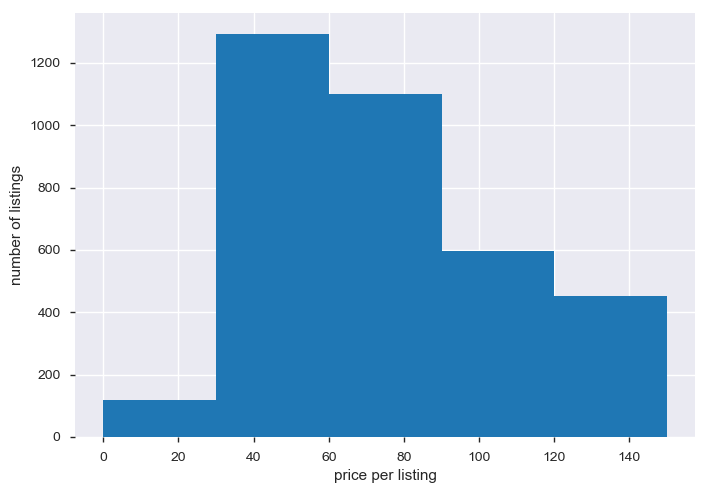

In [75]:
# Plot histogram of price distribution among listings
price_per_listing_histogram = available_relevant_listings["price"].hist(bins=5, range =[0, 150]);
price_per_listing_histogram.set_ylabel("number of listings");
price_per_listing_histogram.set_xlabel("price per listing");

In [76]:
print("Descriptive statistics of price grouped by room_type in available_relevant_listings dataset:")
available_relevant_listings.groupby(["room_type"])["price"].describe()

Descriptive statistics of price grouped by room_type in available_relevant_listings dataset:


count        mean         std   min   25%   50%    75%  \
room_type                                                                  
Entire home/apt  2293.0  133.719145  151.141025   9.0  70.0  98.0  150.0   
Private room     1826.0   72.747536   78.384569   8.0  40.0  55.0   80.0   
Shared room        62.0   67.564516   56.124750  20.0  34.0  49.0   78.0   

                    max  
room_type                
Entire home/apt  5000.0  
Private room     2000.0  
Shared room       300.0

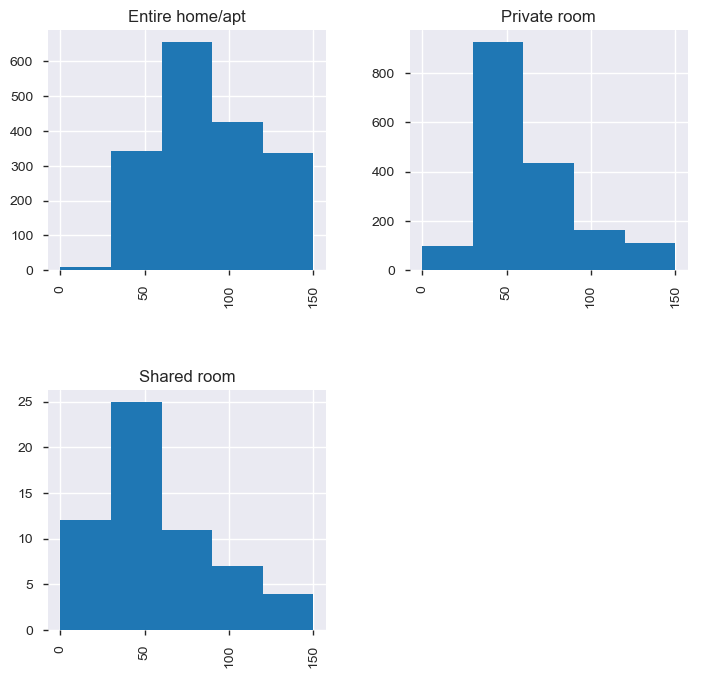

In [77]:
available_relevant_listings.hist(column='price', by='room_type', bins=5, range=[0,150], figsize=(8,8));

In [78]:
print("Descriptive statistics of price grouped by neighbourhood in available_relevant_listings dataset:")
available_relevant_listings.groupby(["neighbourhood"])["price"].describe()

Descriptive statistics of price grouped by neighbourhood in available_relevant_listings dataset:


count        mean  \
neighbourhood                                                           
Allach-Untermenzing                                  23.0   79.565217   
Altstadt-Lehel                                      147.0  151.734694   
Au-Haidhausen                                       261.0  108.463602   
Aubing-Lochhausen-Langwied                           44.0  118.386364   
Berg am Laim                                         94.0   90.085106   
Bogenhausen                                         213.0  100.812207   
Feldmoching-Hasenbergl                               48.0   82.604167   
Hadern                                               45.0   69.666667   
Laim                                                123.0   92.373984   
Ludwigsvorstadt-Isarvorstadt                        443.0  149.742664   
Maxvorstadt                                         421.0  108.667458   
Milbertshofen-Am Hart                               137.0   79.927007   
Moosach                                              72.0   87.097222   
Neuhausen-Nymphenburg                               268.0   92.667910   
Obergiesing                                         133.0   98.887218   
Pasing-Obermenzing                                   98.0   83.418367   
Ramersdorf-Perlach                                  179.0   78.173184   
Schwabing-Freimann                                  239.0   92.661088   
Schwabing-West                                      265.0  105.788679   
Schwanthalerhöhe                                    168.0  132.619048   
Sendling                                            160.0  108.912500   
Sendling-Westpark                                   142.0  100.760563   
Thalkirchen-Obersendling-Forstenried-Fürstenrie...  157.0   78.203822   
Tudering-Riem                                       172.0  111.220930   
Untergiesing-Harlaching                             129.0   97.093023   

                                                           std   min    25%  \
neighbourhood                                                                 
Allach-Untermenzing                                  73.717413  30.0  39.50   
Altstadt-Lehel                                      124.048175  27.0  75.00   
Au-Haidhausen                                        93.296939  25.0  57.00   
Aubing-Lochhausen-Langwied                          165.281468  20.0  35.00   
Berg am Laim                                         62.554176  25.0  50.00   
Bogenhausen                                          69.653336  19.0  55.00   
Feldmoching-Hasenbergl                              119.107629  22.0  45.00   
Hadern                                               47.821638  20.0  35.00   
Laim                                                 84.533280  23.0  40.00   
Ludwigsvorstadt-Isarvorstadt                        280.693673  25.0  65.50   
Maxvorstadt                                          79.575233   8.0  60.00   
Milbertshofen-Am Hart                                63.611254  20.0  45.00   
Moosach                                             114.973746  29.0  49.00   
Neuhausen-Nymphenburg                                63.038822  25.0  50.00   
Obergiesing                                          94.044530  30.0  48.00   
Pasing-Obermenzing                                   63.398905  23.0  44.25   
Ramersdorf-Perlach                                   69.413095  20.0  40.00   
Schwabing-Freimann                                   86.553125  25.0  50.00   
Schwabing-West                                      100.347845  18.0  50.00   
Schwanthalerhöhe                                    116.753582  21.0  65.00   
Sendling                                             99.244466  22.0  50.00   
Sendling-Westpark                                   108.703640  25.0  45.00   
Thalkirchen-Obersendling-Forstenried-Fürstenrie...   57.052578  18.0  45.00   
Tudering-Riem                                       133.154652  25.0  49.00   
Untergiesing-Harlaching   

In [79]:
print("\nMedian price per neighbourhood quantile values:")
for quantil in np.arange(0,1,0.05):
    print("{:.2f} quantile: {:.2f}".format
      (quantil, available_relevant_listings.groupby(["neighbourhood"])["price"].median().quantile(quantil)))


Median price per neighbourhood quantile values:
0.00 quantile: 45.00
0.05 quantile: 50.50
0.10 quantile: 53.50
0.15 quantile: 55.30
0.20 quantile: 59.10
0.25 quantile: 60.00
0.30 quantile: 65.00
0.35 quantile: 65.00
0.40 quantile: 67.40
0.45 quantile: 69.40
0.50 quantile: 70.00
0.55 quantile: 70.00
0.60 quantile: 70.00
0.65 quantile: 70.30
0.70 quantile: 76.50
0.75 quantile: 79.00
0.80 quantile: 80.00
0.85 quantile: 82.00
0.90 quantile: 92.20
0.95 quantile: 99.40


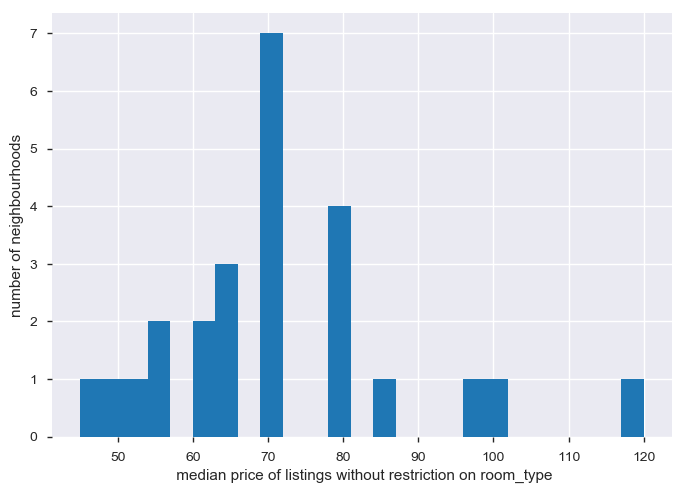

In [80]:
median_price_per_neighbourhood_hist = available_relevant_listings.groupby(["neighbourhood"])["price"].median().hist(bins=25);
median_price_per_neighbourhood_hist.set_ylabel("number of neighbourhoods");
median_price_per_neighbourhood_hist.set_xlabel(" median price of listings without restriction on room_type");

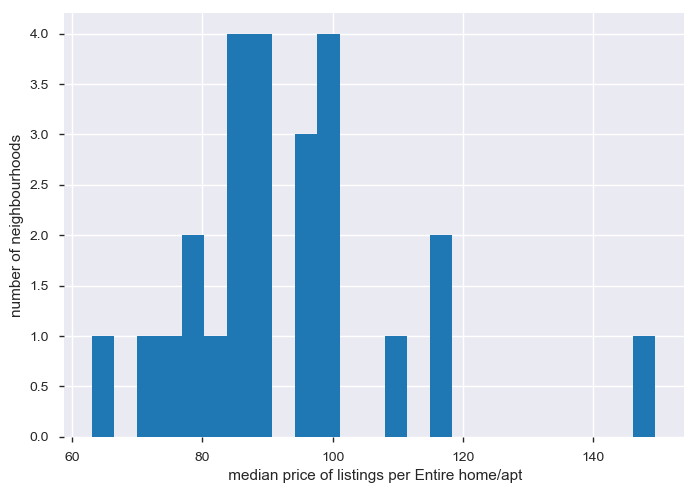

In [81]:
median_price_per_neighbourhood_hist = available_relevant_listings[available_relevant_listings["room_type"]=="Entire home/apt"].groupby(["neighbourhood"])["price"].median().hist(bins=25);
median_price_per_neighbourhood_hist.set_ylabel("number of neighbourhoods");
median_price_per_neighbourhood_hist.set_xlabel(" median price of listings per Entire home/apt");

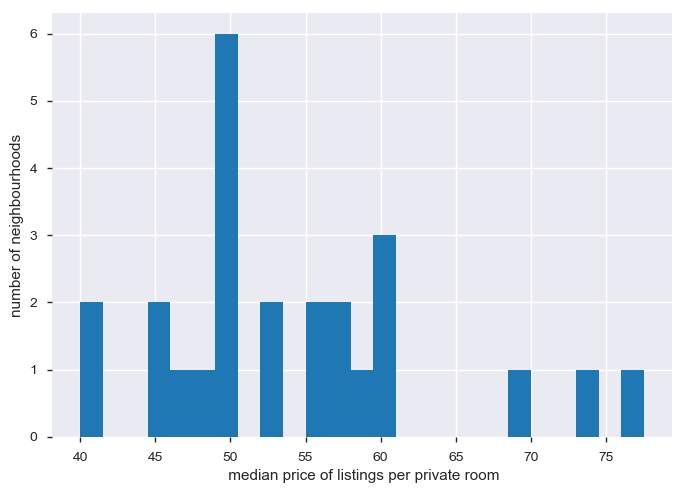

In [82]:
median_price_per_neighbourhood_hist = available_relevant_listings[available_relevant_listings["room_type"]=="Private room"].groupby(["neighbourhood"])["price"].median().hist(bins=25);
median_price_per_neighbourhood_hist.set_ylabel("number of neighbourhoods");
median_price_per_neighbourhood_hist.set_xlabel(" median price of listings per private room");

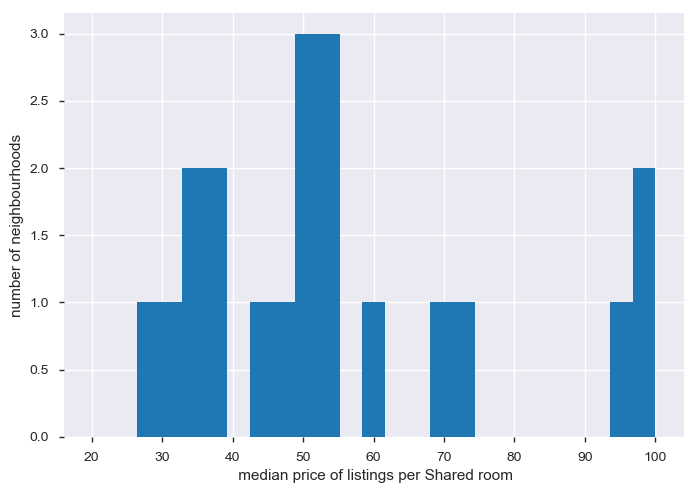

In [83]:
median_price_per_neighbourhood_hist = available_relevant_listings[available_relevant_listings["room_type"]=="Shared room"].groupby(["neighbourhood"])["price"].median().hist(bins=25, range=[20,100]);
median_price_per_neighbourhood_hist.set_ylabel("number of neighbourhoods");
median_price_per_neighbourhood_hist.set_xlabel(" median price of listings per Shared room");

### Conclusion on descriptive statistics ###
* Overall price distribution:
    * less than 5% of listings have a price below 32 USD per night.
    * less than 15% of listings have a price above 150 USD per night.
    * 50% of listings have a price in the range between 50 USD and 120 USD per night.
* Descriptive statistics of price related to features neighbourhood and room_type:
    * **price distribution by room_type**:
        * considerable differences between the different room types.
        * Median prices:
            * Entire homes/ apartments rank highest median price at 98 USD.
            * Private rooms rank second at 55 USD.
            * Shared rooms rank third at 49 USD.
        * Price distributions between room types are also quite different.
    * **price distribution by neighbourhood**:
        * considerable differences between the neighbourhoods are visible.
        * 65% of all neighbourhoods have a median listing price between 45 and 70.3 USD.
        * 35% of all neighbourhoods have a median listing price between 70.3 and 120 USD.
        * out of 5 median price groups, the largest group (7 neighbourhoods) has a median price between 60 and 75 USD.
    * **distribution of median price per room_type by neighbourhood**:
        * considerable differences can be seen for the different neighbourhoods.
        * median price by neighourhood for room type:
            * Entire homes/ apartments: most neighbourhoods have a median price over all listings between 80 and 100 USD
            * Private rooms: a large group of neighbourhoods has a median price of ca 50 USD. Most of the neighbourhood have a median price below 65 USD.
            * Shared rooms: in the price range below 60 USD, the distribution is similar to private rooms. Striking is a group of neighbourhoods with a high median price between 90 and 100 USD.

# (4) Influence of listing properties on price #
## (4.1) Data preparation ##

* The profile report on the dataset "available_relevant_listings" shows there are 12 features besides from the index.
* These features are of the following type:
    * Numeric:	8
    * Categorical:	3
    * Date	1
    
* For further analysis the categorical features need to be one-hot encoded. This will greatly increase the number of features = dimensionalty.
* For dimensionality reduction a principal component analysis shall be applied on theses features. The price feature is excluded from this analysis.
* Afterwards supervised learning method shall be applied to determine a possible price function.

In [84]:
print("Data types in dataset available_relevant_listings:")
available_relevant_listings.dtypes

Data types in dataset available_relevant_listings:


name                         object
neighbourhood                object
latitude                    float64
longitude                   float64
room_type                    object
price                         int64
minimum_nights                int64
number_of_reviews             int64
last_review          datetime64[ns]
reviews_per_month           float64
availability_365              int64
dtype: object

### (4.1.1) Encoding categorical features ###

In [85]:
# analyse categorical features and drop those with too many categories
# encoded_available_relevant_listings = 
encoded_available_relevant_listings = drop_features_w_many_categories(available_relevant_listings, category_limit=3)        
# one-hot encode remaining categorical features
encoded_available_relevant_listings = one_hot_encode_and_drop_original_category(encoded_available_relevant_listings)

Categorical feature name is removed from dataset since number of categories is over limit of 3
Categorical feature neighbourhood is removed from dataset since number of categories is over limit of 3
One-hot encode categorical feature room_type and drop original category
New features from unique categorical values: 3


In [86]:
print("Manually remove feature last_review since type datetime cannot be used in PCA")
encoded_available_relevant_listings = encoded_available_relevant_listings.drop("last_review", axis =1)
encoded_available_relevant_listings_wo_price = encoded_available_relevant_listings.drop("price", axis =1)
print("Shape of encoded listing dataset with price feature: {}".format(encoded_available_relevant_listings.shape))
print("Shape of encoded listing dataset without price feature: {}".format(encoded_available_relevant_listings_wo_price.shape))

Manually remove feature last_review since type datetime cannot be used in PCA
Shape of encoded listing dataset with price feature: (4181, 10)
Shape of encoded listing dataset without price feature: (4181, 9)


### (4.1.2) Features Scaling ###

In [87]:
# Scale dataset without price for PCA
df = encoded_available_relevant_listings_wo_price
scaler = StandardScaler();
scaled_available_relevant_listings_wo_price = pd.DataFrame(scaler.fit_transform(df),columns=df.columns);
scaled_prices = scaler.fit_transform(encoded_available_relevant_listings["price"].values.reshape(-1, 1))
#scaled_available_relevant_listings_wo_price.describe()

C:\Users\Boffmasta\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Boffmasta\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Boffmasta\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Boffmasta\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### (4.1.3) Dimensionality Reduction via PCA ###

#### Analyse influence of number of principal components ####

In [88]:
# Apply PCA to the data.
pca_all = PCA()
X_pca_all = pca_all.fit_transform(scaled_available_relevant_listings_wo_price)

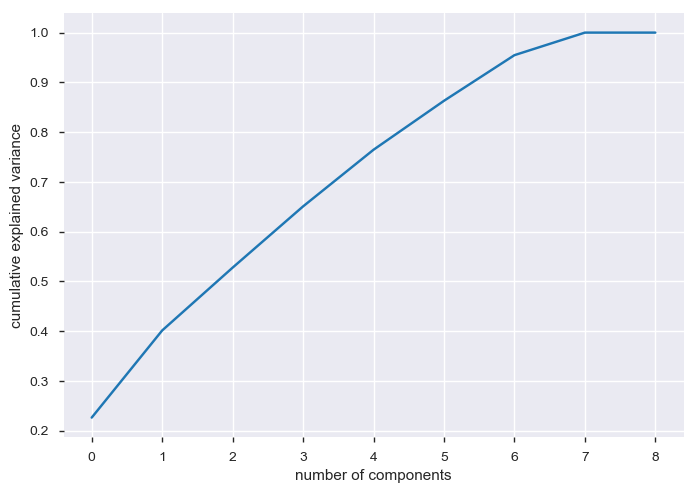

In [89]:
plot_pca_explained_variance(pca_all)

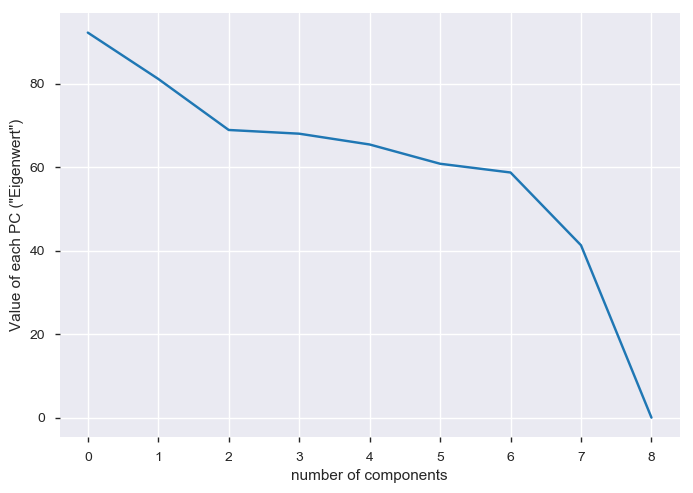

In [90]:
plot_pca_eigenwert(pca_all)

#### Conclusions on influence of number of principal components ####
* based on the plots that show the course of explained variance and eigenwert over the number of components it appear that **4 principal components** may be sufficient to explanin more that 75% data variance.
* Therefore the analysis will continue with these 4 components.

In [91]:
pc_number = 4
pca_selection = PCA(n_components=pc_number)
X_pca_selection = pca_selection.fit_transform(scaled_available_relevant_listings_wo_price)

In [92]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
for number in range(1, pc_number+1):
    map_pca_components_to_features(pca_selection, scaled_available_relevant_listings_wo_price, pc=number)

Weight of all features in component: 1
room_type_Entire home/apt    0.677413
minimum_nights               0.146952
latitude                     0.033407
longitude                    0.001971
room_type_Shared room       -0.030973
availability_365            -0.115334
reviews_per_month           -0.153885
number_of_reviews           -0.169353
room_type_Private room      -0.672142
Name: 1, dtype: float64

Weight of all features in component: 2
reviews_per_month            0.682030
number_of_reviews            0.641434
room_type_Entire home/apt    0.165129
longitude                    0.068525
latitude                     0.049160
room_type_Shared room       -0.045660
room_type_Private room      -0.154557
minimum_nights              -0.176550
availability_365            -0.178536
Name: 2, dtype: float64

Weight of all features in component: 3
availability_365             0.635286
room_type_Shared room        0.363196
minimum_nights               0.362361
longitude                    0.3343

#### Interpretation of feature weights in principal components ####
* Feature 1: 
    * strong positive influence of room_type_Entire home/apt    
    * strong negative influence of room_type_Private room
    * negative influence of number_of_reviews and reviews_per_month
    * positive influence of minimum_nights
    * location has barely any influence
    * **Summary: factor favours room type Entire home/apt and penalizes Private rooms, location independent.**
* Feature 2:
    * strong positive influence of reviews_per_month and number_of_reviews
    * negative influence of availability_365, minimum_nights, room_type_Private room
    * positive influence of room_type_Entire home/apt
    * location has barely any influence 
    * **Summary: factor favours listings that are booked often and often entire homes/apts, location independent.**
* Feature 3:
    * strong positive influence of availability_365, room_type_Shared room, minimum_nights
    * strong influence of location
    * positive influence of number_of_reviews
    * negative influence of room_type_Private room
    * **Summary: factor favours shared rooms with high availability, location is very important as well**
* Feature 4:
    * strong influence of location
    * strong positive influence of room_type_Shared room
    * positive influence of availability_365, minimum_nights, number_of_reviews
    * **Summary: factor favours location and shared rooms**

## (4.2) Modeling ##

In [93]:
X = X_pca_selection
y = scaled_prices
# split data in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [94]:
price_regressor = LinearRegression()  
price_regressor.fit(X_train, y_train) #training regression model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### (4.3) Evaluation ###


In [95]:
print("Intercept of price function: {:.2f}".format(price_regressor.intercept_[0]))
print("Slope of function: {}".format(price_regressor.coef_))
y_pred = price_regressor.predict(X_test)
print("Variance R2 score of price function model: {:.2f}".format(metrics.r2_score(y_test, y_pred)))
print("Root mean squared error of price function model: {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Intercept of price function: -0.00
Slope of function: [[ 0.15911984 -0.04515637  0.0132767  -0.03736133]]
Variance R2 score of price function model: 0.04
Root mean squared error of price function model: 1.50


#### Conclusion on evaluation of price function model ###
* the variance score (R2) is a measure for model fit. A score of 0 means the model cannot predict at all the value, 1 means perfect prediction. The variance score of this model close to zero means this model is useless for prediction.
* Also the root mean square error is at 1.5 unacceptably high considering that the data is standard scaled (mean of zero, standard deviation of 1).

#### Possible improvements for modeling ###
* choosing a more suitable estimator.
* including more available features into the analysis. For this the data set listings_detailed may be used, or data from the sets "calendar" and "reviews" could be joined to the listings data.

## (4.4) Deployment ##
No model deployment should be done due to poor model performance. Instead a return to the following steps in the CRISP-DM process is suggested: 
* to step 1: re-formulation of different business relevant questions.
* to step 2: analysis of more data, e.g. from set listings_detailed, "calendar" or "reviews".

# (5) Analysis of Oktoberfest effect on Munich listings #
## (5.1) Data preparation ##

In [96]:
# create new feature "oktoberfest_effect" 
# from feature date with values between from 2019-09-21 until 2019-10-06
start_date = "2019-09-21"
end_date = "2019-10-06"

In [97]:
clean_calendar["oktoberfest_effect"] = (clean_calendar['date'] >= start_date) & (clean_calendar['date'] <= end_date)

In [98]:
# verify that feature "oktoberfest_effect" matches with correct dates
print("Dates in subset with oktoberfest_effect:\n")
clean_calendar[clean_calendar["oktoberfest_effect"]==True]["date"].unique()

Dates in subset with oktoberfest_effect:



array(['2019-09-21T00:00:00.000000000', '2019-09-22T00:00:00.000000000',
       '2019-09-23T00:00:00.000000000', '2019-09-24T00:00:00.000000000',
       '2019-09-25T00:00:00.000000000', '2019-09-26T00:00:00.000000000',
       '2019-09-27T00:00:00.000000000', '2019-09-28T00:00:00.000000000',
       '2019-09-29T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-10-02T00:00:00.000000000',
       '2019-10-03T00:00:00.000000000', '2019-10-04T00:00:00.000000000',
       '2019-10-05T00:00:00.000000000', '2019-10-06T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [99]:
# print data rows for subsets depending on "oktober_effect" that are available
print("Data rows in subset with Oktoberfest effect that are available: {}".format(
    clean_calendar[(clean_calendar["oktoberfest_effect"]==True)&(clean_calendar["available"]=="t")].shape[0]))
print("Data rows in subset without Oktoberfest effect that are available: {}".format( 
    clean_calendar[(clean_calendar["oktoberfest_effect"]==False)&(clean_calendar["available"]=="t")].shape[0]))

Data rows in subset with Oktoberfest effect that are available: 24657
Data rows in subset without Oktoberfest effect that are available: 657098


In [100]:
# get mean of prices for each listing_id in days without Oktoberfest (oktoberfest_effect = 0)
# and days during Oktoberfest
oktoberfest_median_price = clean_calendar[(clean_calendar["oktoberfest_effect"]==True)&(clean_calendar["available"]=="t")].groupby("listing_id")["price"].median()
nofest_median_price = clean_calendar[(clean_calendar["oktoberfest_effect"]==False)&(clean_calendar["available"]=="t")].groupby("listing_id")["price"].median()

In [101]:
# ensure to compare only listings that are in both groups differentiated to Oktoberfest_effect
listing_id_intersection = oktoberfest_median_price.index.intersection(nofest_median_price.index)
median_price_per_listing = pd.DataFrame({"oktoberfest_median_price":oktoberfest_median_price[listing_id_intersection],
                                        "nofest_median_price":nofest_median_price[listing_id_intersection]})

In [102]:
median_price_per_listing.describe()

oktoberfest_median_price  nofest_median_price
count               2463.000000          2463.000000
mean                 212.453918           131.841251
std                  206.511742           154.765780
min                   12.500000            16.000000
25%                   90.000000            59.000000
50%                  150.000000            88.000000
75%                  250.500000           150.000000
max                 3000.000000          3000.000000

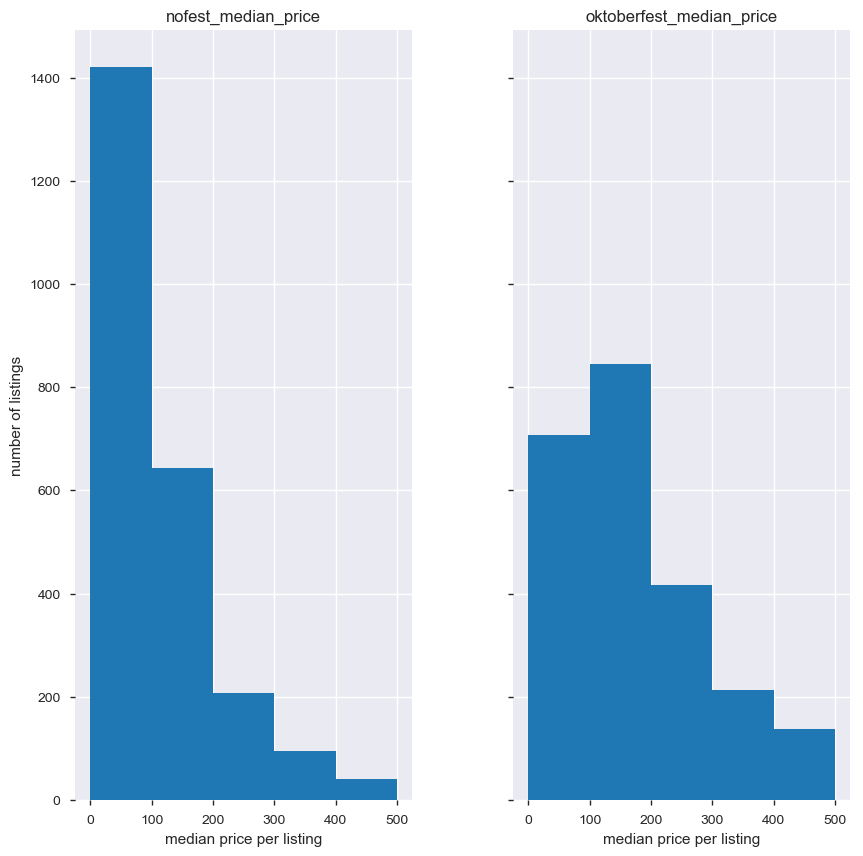

In [103]:
# Plot histogram of median price distribution among listings
price_per_listing_histograms = median_price_per_listing[["nofest_median_price", "oktoberfest_median_price"]].hist(bins=5, range =[0, 500], sharey= True, figsize=(10,10));
for histogram in price_per_listing_histograms[0]:
    histogram.set_ylabel("number of listings")
    histogram.set_xlabel("median price per listing")

In [104]:
# perform linear regression on median_price to evaluate "oktoberfest_effect" for prediction based on price troughout the year
X = median_price_per_listing["nofest_median_price"].values.reshape(-1,1)
y = median_price_per_listing["oktoberfest_median_price"].values.reshape(-1,1)

### Findings of descriptive statistics and frequency distribution of median price per listing during Oktoberfest and throughout the rest of the year ###
* descriptive statistics indicates that there is a positive effect of the Oktoberfest on the median prices of a listing: e.g. the median value of all listings increases by 70.5%.
* the frequency distribution confirms this indication.

## (5.2) Modeling ##

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [106]:
oktoberfest_regressor = LinearRegression()  
oktoberfest_regressor.fit(X_train, y_train) #training regression model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## (5.3) Evaluation ##

In [107]:
print("Intercept of Oktoberfest effect: {:.2f}".format(oktoberfest_regressor.intercept_[0]))
print("Slope of Oktoberfest effect: {:.4f}".format(oktoberfest_regressor.coef_[0][0]))
y_pred = oktoberfest_regressor.predict(X_test)
print("Variance R2 score of Oktoberfest effect model: {:.2f}".format(metrics.r2_score(y_test, y_pred)))
print("Root mean squared error of Oktoberfest effect model: {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Intercept of Oktoberfest effect: 73.61
Slope of Oktoberfest effect: 1.0635
Variance R2 score of Oktoberfest effect model: 0.57
Root mean squared error of Oktoberfest effect model: 110.43


### Conclusion on influence mean price throughout rest of the year on price during Oktoberfest ###
* the magnitude of the Oktoberfest effect is indicated by the model slope of 1.0635. This means that the price of listing increases by 6.35% when there is the Oktoberfest compared to the rest of the year.
* the variance score (R2) is a measure for model fit. A score of 0 means the model cannot predict at all the value, 1 means perfect prediction. The variance score of the Oktoberfest effect model is 0.57 and explains therefore not well the variance in the data.
* The root mean square error is at 110.43 inacceptibly high. This value is at ca 74% of the mean price of all listings during the Oktoberfest. The model is therefore not very accurate.

**Conclusion:** 
* **the histograms show that there is a higher distribution of high price listings during the time of the Oktoberfest.** 
* **The linear regression model results indicate that higher listing prices are  not solely caused by the fact that the Oktoberfest is happening.**
* **Further analysis on the factors that influence a higher price is therefore required.**

Suggestion for further analysis:
* analyse frequency distribution of ratio oktoberfest_median_price/ nofest_median_price per listing

count    2463.000000
mean        1.859968
std         1.219906
min         0.320000
25%         1.000000
50%         1.530000
75%         2.330000
max        25.360000
Name: oktoberfest_to_nofest_ratio, dtype: float64

oktoberfest_to_nofest_ratio quantile values:
0.00 quantile: 0.32
0.05 quantile: 0.94
0.10 quantile: 1.00
0.15 quantile: 1.00
0.20 quantile: 1.00
0.25 quantile: 1.00
0.30 quantile: 1.00
0.35 quantile: 1.00
0.40 quantile: 1.17
0.45 quantile: 1.36
0.50 quantile: 1.53
0.55 quantile: 1.71
0.60 quantile: 1.87
0.65 quantile: 2.00
0.70 quantile: 2.17
0.75 quantile: 2.33
0.80 quantile: 2.58
0.85 quantile: 2.84
0.90 quantile: 3.14
0.95 quantile: 3.88


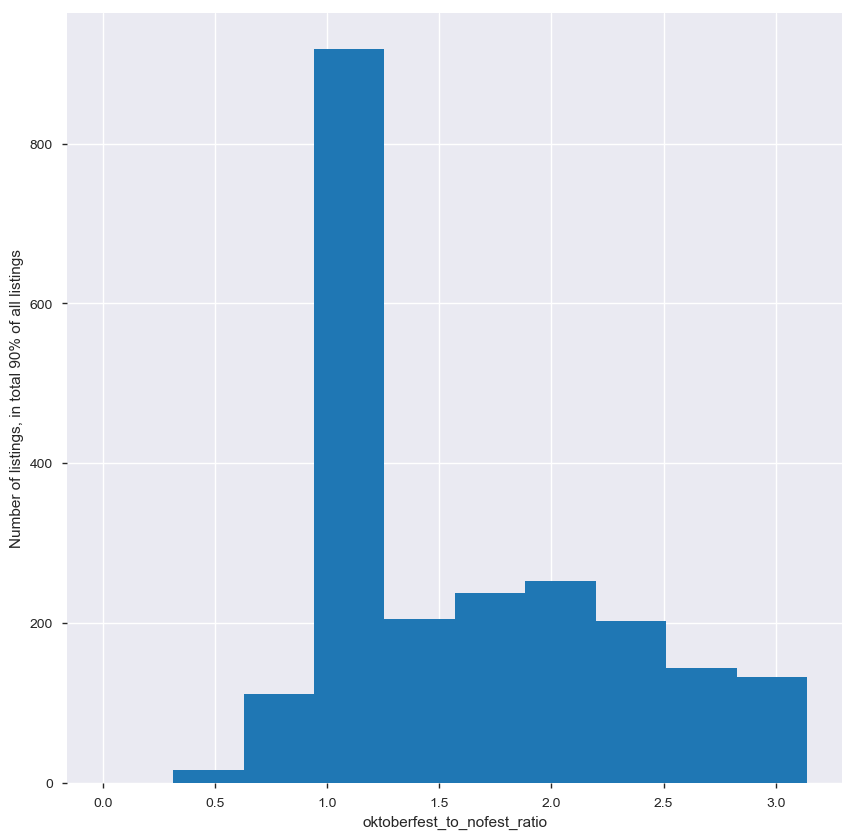

In [108]:
# add feature "oktoberfest_to_nofest_ratio" which is ratio of oktoberfest_median_price/ nofest_median_price per listing
median_price_per_listing["oktoberfest_to_nofest_ratio"] = (median_price_per_listing["oktoberfest_median_price"]/
                                                           median_price_per_listing["nofest_median_price"]).round(2)
print(median_price_per_listing["oktoberfest_to_nofest_ratio"].describe())

print("\noktoberfest_to_nofest_ratio quantile values:")
for quantil in np.arange(0,1,0.05):
    print("{:.2f} quantile: {:.2f}".format
      (quantil, median_price_per_listing["oktoberfest_to_nofest_ratio"].quantile(quantil)))

# Plot histogram of feature "oktoberfest_to_nofest_ratio"
ratio_histogram = median_price_per_listing["oktoberfest_to_nofest_ratio"].hist(bins=10, range =[0, 3.14], figsize=(10,10));
ratio_histogram.set_xlabel('oktoberfest_to_nofest_ratio');
ratio_histogram.set_ylabel('Number of listings, in total 90% of all listings');

### Analysis results for frequency distribution of ratio oktoberfest_median_price/ nofest_median_price per listing ###
* the results of the frequency distribution shone more light into the effect that the Oktoberfest might have on certain listings.
* From the frequency distribution of the price ratio Oktoberfest/ Nofest the following can be seen:
    * 5% of all listing have throughout the rest of the year a median price that is higher the mean price during the Oktoberfest. 
    * 25% of all listings have no change in the mean price during the Oktoberfest.
    * 10% of all listings have a median price during the Oktoberfest that is between 1 and 1.5 times higher than during the rest of the year.
    * 45% of all listings have a median price during the Oktoberfest that is between 1.5 and 3.1 times higher than during the rest of the year.
    * 5% of 45% of all listings have a median price during the Oktoberfest that is more than 3.1 times higher than during the rest of the year. 
    
**Conclusion:** 
* **From a business point of the view further analysis of listings with significantly higher prices during the Oktoberfest (more than 1.5 times the median price of the remaining year) should be done.** 
* **A clustering methods could be applied in order to determine whether these listings share feature values that might have an influence on price.**

## (5.4) Deployment ##
No model deployment should be done due to poor model performance. Instead a return to the following steps in the CRISP-DM process is suggested:
* to step 1: re-formulation of different business relevant questions. Questions might be further curtailed to certain subsets of the date, e.g. those with a significantly higher price during the Oktoberfest.
* to step 2: analysis of more data, e.g. via a join of features from other sets to the calendar data. Clustering methods could be applied in order to find listings that share similar price changes during the Oktoberfest period.

# (6) Conclusion #
Returning to the questions from business understanding (1), the following can be said about Airbnb listings in Munich:
1. Appropriate price for a listing (chapter 3): even though a suitable model for the determination could not established in this analysis, the descriptive statistics provide a reference for the current price ranges. 
2. Influence of listing properties on price (chapter 4): 
    * Room type and neighbourhood appear to have a high effect on listing prices. 
    * However an in detail analysis of more features is required in order to derive any suitable model for prediction.
3. Oktoberfest effect on Airbnb prices (chapter 5): 
    * also here a suitable model could not be established, analysis of more data is required. 
    * Again descriptive statistics illustrates that there is a significant change in prices during the Oktoberfest for some features, but crucially not all.

For me personally an eye opener in this project was the high effort for data understanding and corresponding preparation.

This blog post and analysis was done as a project within the Udacity Data Science Nanodegree. I really appreciate any feedback on possible improvements in code, modeling and general problem-solving approach.